In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
from datetime import datetime, timedelta

import keras
import tensorflow

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Any results you write to the current directory are saved as output.
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [35]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [8]:
df = pd.read_csv("combined_energy_data.csv", low_memory=False)

In [9]:
df = df.drop_duplicates(subset=['datetime'])

In [10]:
df['datetime'] = df['datetime'].apply(lambda x: x.split("+")[0])

In [11]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [12]:
columns_use = ['datetime', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N)',
       'boissy-la-riviere_Speed(m/s)', 'boissy-la-riviere_Direction (deg N)',
       'angerville-1_Speed(m/s)', 'angerville-1_Direction (deg N)',
       'angerville-2_Speed(m/s)', 'angerville-2_Direction (deg N)',
       'guitrancourt-b_Speed(m/s)', 'guitrancourt-b_Direction (deg N)',
       'lieusaint-b_Speed(m/s)', 'lieusaint-b_Direction (deg N)',
       'lvs-pussay-b_Speed(m/s)', 'lvs-pussay-b_Direction (deg N)',
       'parc-du-gatinais-b_Speed(m/s)', 'parc-du-gatinais-b_Direction (deg N)',
       'arville-b_Speed(m/s)', 'arville-b_Direction (deg N)',
       'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)']

In [13]:
agg_df = df[['datetime','Wind']].groupby([df['datetime'].dt.floor('H')]).agg(['mean','sum','std'])
agg_df.columns = agg_df.columns.map('_'.join)
agg_df = agg_df.reset_index()
merge_df = agg_df.merge(df[columns_use], how='left', on='datetime')
merge_df = merge_df.fillna(method='ffill')

In [14]:
data = merge_df.copy()

In [15]:
data

,datetime,Wind_mean,Wind_sum,Wind_std,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N),lieusaint_Speed(m/s),lieusaint_Direction (deg N),lvs-pussay_Speed(m/s),lvs-pussay_Direction (deg N),parc-du-gatinais_Speed(m/s),parc-du-gatinais_Direction (deg N),arville_Speed(m/s),arville_Direction (deg N),boissy-la-riviere_Speed(m/s),boissy-la-riviere_Direction (deg N),angerville-1_Speed(m/s),angerville-1_Direction (deg N),angerville-2_Speed(m/s),angerville-2_Direction (deg N),guitrancourt-b_Speed(m/s),guitrancourt-b_Direction (deg N),lieusaint-b_Speed(m/s),lieusaint-b_Direction (deg N),lvs-pussay-b_Speed(m/s),lvs-pussay-b_Direction (deg N),parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N)
0,2016-12-31 23:00:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 00:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0
2,2017-01-01 01:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0
3,2017-01-01 02:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0
4,2017-01-01 03:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31013,2020-07-16 17:00:00,1750.0,0.0,0.0,2.91,309.0,3.54,292.0,3.48,301.0,3.62,293.0,3.61,292.0,3.61,296.0,3.46,299.0,3.47,299.0,4.83,331.0,4.73,333.0,4.58,339.0,2.62,318.0,2.79,321.0,4.47,338.0,4.39,338.0,4.40,338.0
31014,2020-07-16 18:00:00,1750.0,0.0,0.0,2.84,338.0,1.82,297.0,1.72,302.0,2.19,288.0,2.14,288.0,1.76,293.0,1.68,299.0,1.68,299.0,4.17,337.0,3.51,344.0,3.45,357.0,3.57,350.0,3.57,349.0,3.42,353.0,3.46,357.0,3.46,357.0
31015,2020-07-16 19:00:00,1750.0,0.0,0.0,2.84,338.0,1.82,297.0,1.72,302.0,2.19,288.0,2.14,288.0,1.76,293.0,1.68,299.0,1.68,299.0,4.17,337.0,3.51,344.0,3.45,357.0,3.57,350.0,3.57,349.0,3.42,353.0,3.46,357.0,3.46,357.0
31016,2020-07-16 20:00:00,1750.0,0.0,0.0,2.84,338.0,1.82,297.0,1.72,302.0,2.19,288.0,2.14,288.0,1.76,293.0,1.68,299.0,1.68,299.0,4.17,337.0,3.51,344.0,3.45,357.0,3.57,350.0,3.57,349.0,3.42,353.0,3.46,357.0,3.46,357.0


In [16]:
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek
data['quarter'] = data['datetime'].dt.quarter
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year 
data['dayofyear'] = data['datetime'].dt.dayofyear
data['dayofmonth'] = data['datetime'].dt.day
data['weekofyear'] = data['datetime'].dt.weekofyear

In [23]:
data

,datetime,Wind_mean,Wind_sum,Wind_std,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N),lieusaint_Speed(m/s),lieusaint_Direction (deg N),lvs-pussay_Speed(m/s),lvs-pussay_Direction (deg N),parc-du-gatinais_Speed(m/s),parc-du-gatinais_Direction (deg N),arville_Speed(m/s),arville_Direction (deg N),boissy-la-riviere_Speed(m/s),boissy-la-riviere_Direction (deg N),angerville-1_Speed(m/s),angerville-1_Direction (deg N),angerville-2_Speed(m/s),angerville-2_Direction (deg N),guitrancourt-b_Speed(m/s),guitrancourt-b_Direction (deg N),lieusaint-b_Speed(m/s),lieusaint-b_Direction (deg N),lvs-pussay-b_Speed(m/s),lvs-pussay-b_Direction (deg N),parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2016-12-31 23:00:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,5,4,12,2016,366,31,52
1,2017-01-01 00:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0,0,6,1,1,2017,1,1,52
2,2017-01-01 01:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0,1,6,1,1,2017,1,1,52
3,2017-01-01 02:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0,2,6,1,1,2017,1,1,52
4,2017-01-01 03:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0,3,6,1,1,2017,1,1,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31013,2020-07-16 17:00:00,1750.0,0.0,0.0,2.91,309.0,3.54,292.0,3.48,301.0,3.62,293.0,3.61,292.0,3.61,296.0,3.46,299.0,3.47,299.0,4.83,331.0,4.73,333.0,4.58,339.0,2.62,318.0,2.79,321.0,4.47,338.0,4.39,338.0,4.40,338.0,17,3,3,7,2020,198,16,29
31014,2020-07-16 18:00:00,1750.0,0.0,0.0,2.84,338.0,1.82,297.0,1.72,302.0,2.19,288.0,2.14,288.0,1.76,293.0,1.68,299.0,1.68,299.0,4.17,337.0,3.51,344.0,3.45,357.0,3.57,350.0,3.57,349.0,3.42,353.0,3.46,357.0,3.46,357.0,18,3,3,7,2020,198,16,29
31015,2020-07-16 19:00:00,1750.0,0.0,0.0,2.84,338.0,1.82,297.0,1.72,302.0,2.19,288.0,2.14,288.0,1.76,293.0,1.68,299.0,1.68,299.0,4.17,337.0,3.51,344.0,3.45,357.0,3.57,350.0,3.57,349.0,3.42,353.0,3.46,357.0,3.46,357.0,19,3,3,7,2020,198,16,29
31016,2020-07-16 20:00:00,1750.0,0.0,0.0,2.84,338.0,1.82,297.0,1.72,302.0,2.19,288.0,2.14,288.0,1.76,293.0,1.68,299.0,1.68,299.0,4.17,337.0,3.51,344.0,3.45,357.0,3.57,350.0,3.57,349.0,3.42,353.0,3.46,357.0,3.46,357.0,20,3,3,7,2020,198,16,29


In [21]:
x = data.datetime
y = data['Wind_sum']
hour = data['hour'].astype(int)
quart_day = hour // 4

In [27]:
plt.rcParams["figure.figsize"] = (20, 9)

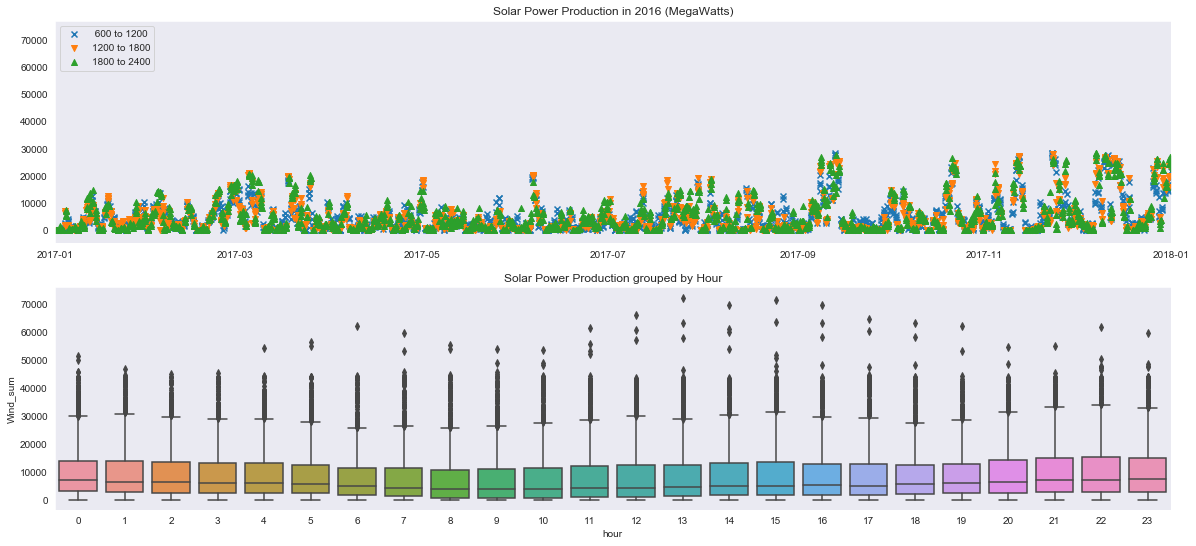

In [28]:
plt.subplot(2, 1, 1)

for h, marker in [(1, 'x'), (2, 'v'), (3, '^')]:
    mask = quart_day == h
    plt.scatter(x[mask], y[mask], marker=marker,  # c=hour[mask].norm(),
                label='{:2}00 to {:2}00'.format(h*6, (h+1)*6))
plt.legend(loc='upper left')
plt.xlim([pd.to_datetime('01/01/2017'), pd.to_datetime('01/01/2018')])
plt.title('Wind Power Production in 2017 (MegaWatts)')

# Add the season change lines
#seasons = [(pd.to_datetime('June 20, 2016'), 'Summer Solstice'),
#           (pd.to_datetime('December 21, 2016'), 'Winter Solstice'),
#           (pd.to_datetime('September 22, 2016'), 'Fall Equinox'),
#           (pd.to_datetime('March 20, 2016'), 'Spring Equinox'),
#           ]

#for s, name in seasons:
#    plt.axvline(s)
#    plt.text(s, 8000, name.replace(' ', '\n'))


plt.subplot(2, 1, 2)
sns.boxplot(hour, y)

plt.title('Wind Power Production grouped by Hour')
plt.show()

In [37]:
data

,datetime,Wind_mean,Wind_sum,Wind_std,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N),lieusaint_Speed(m/s),lieusaint_Direction (deg N),lvs-pussay_Speed(m/s),lvs-pussay_Direction (deg N),parc-du-gatinais_Speed(m/s),parc-du-gatinais_Direction (deg N),arville_Speed(m/s),arville_Direction (deg N),boissy-la-riviere_Speed(m/s),boissy-la-riviere_Direction (deg N),angerville-1_Speed(m/s),angerville-1_Direction (deg N),angerville-2_Speed(m/s),angerville-2_Direction (deg N),guitrancourt-b_Speed(m/s),guitrancourt-b_Direction (deg N),lieusaint-b_Speed(m/s),lieusaint-b_Direction (deg N),lvs-pussay-b_Speed(m/s),lvs-pussay-b_Direction (deg N),parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2016-12-31 23:00:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,5,4,12,2016,366,31,52
1,2017-01-01 00:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0,0,6,1,1,2017,1,1,52
2,2017-01-01 01:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0,1,6,1,1,2017,1,1,52
3,2017-01-01 02:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0,2,6,1,1,2017,1,1,52
4,2017-01-01 03:00:00,0.0,0.0,0.0,1.86,212.0,1.50,223.0,1.71,222.0,1.45,222.0,1.45,223.0,1.66,223.0,1.67,222.0,1.67,222.0,3.07,221.0,2.76,221.0,2.76,229.0,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0,3,6,1,1,2017,1,1,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31013,2020-07-16 17:00:00,1750.0,0.0,0.0,2.91,309.0,3.54,292.0,3.48,301.0,3.62,293.0,3.61,292.0,3.61,296.0,3.46,299.0,3.47,299.0,4.83,331.0,4.73,333.0,4.58,339.0,2.62,318.0,2.79,321.0,4.47,338.0,4.39,338.0,4.40,338.0,17,3,3,7,2020,198,16,29
31014,2020-07-16 18:00:00,1750.0,0.0,0.0,2.84,338.0,1.82,297.0,1.72,302.0,2.19,288.0,2.14,288.0,1.76,293.0,1.68,299.0,1.68,299.0,4.17,337.0,3.51,344.0,3.45,357.0,3.57,350.0,3.57,349.0,3.42,353.0,3.46,357.0,3.46,357.0,18,3,3,7,2020,198,16,29
31015,2020-07-16 19:00:00,1750.0,0.0,0.0,2.84,338.0,1.82,297.0,1.72,302.0,2.19,288.0,2.14,288.0,1.76,293.0,1.68,299.0,1.68,299.0,4.17,337.0,3.51,344.0,3.45,357.0,3.57,350.0,3.57,349.0,3.42,353.0,3.46,357.0,3.46,357.0,19,3,3,7,2020,198,16,29
31016,2020-07-16 20:00:00,1750.0,0.0,0.0,2.84,338.0,1.82,297.0,1.72,302.0,2.19,288.0,2.14,288.0,1.76,293.0,1.68,299.0,1.68,299.0,4.17,337.0,3.51,344.0,3.45,357.0,3.57,350.0,3.57,349.0,3.42,353.0,3.46,357.0,3.46,357.0,20,3,3,7,2020,198,16,29


In [40]:
# Get the raw data values from the pandas data frame.
data_raw = data.drop(columns=['datetime']).values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

In [41]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (18610, 12408)
